In [1]:
# Load Libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [2]:
# Import Data
df = pd.read_csv("/Users/genoc/Desktop/HyannisHarborHawks/Trackman/CapeTrackmanDatabase.csv",low_memory=False)

# Clean Trackman Data
dft = df[['Pitcher', 'PitcherTeam', 'Batter', 'BatterTeam', 'PitcherThrows', 'RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak', 'PitchCall', 'PlayResult', 'TaggedHitType', 'KorBB']]

#Rename the columns to be more descriptive
dft.rename(columns={'BatterTeam':'Batter Team', 'PitcherTeam':'Pitcher Team', 'PitcherThrows':'P Side', 'RelSpeed':'Velocity', 'SpinRate':'Spin Rate', 'RelHeight':'Release Height', 'RelSide':'Release Side', 'Extension':'Extension', 'InducedVertBreak':'Induced Vertical Break', 'HorzBreak':'Horizontal Break', 'PitchCall':'Pitch Call', 'PlayResult':'Play Result', 'TaggedHitType':'Hit Type'}, inplace=True)

#Add the Pitch Type and Pitch Result to the new dataframe
dft.insert(1, 'Pitch Type', df['TaggedPitchType'])
dft.insert(2, 'Pitch Result', df['PitchCall'])

#Create a new column for the difference between the Induced Vertical Break and the Horizontal Break (Absolute Value)
dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()

#Add two new columns for Pitch Location
dft.insert(10, 'Pitch Height', df['PlateLocHeight'])
dft.insert(11, 'Pitch Side', df['PlateLocSide'])
dft.insert(12, 'Vertical Approach Angle', df['VertApprAngle'])
dft.insert(13, 'Horizontal Approach Angle', df['HorzApprAngle'])

#Edit Horizontal Break to be absolute value of horizontal break
dft['Horizontal Break'] = abs(dft['Horizontal Break'])

dft['Release Side'] = abs(dft['Release Side'])

# Edit the pitcher names so the first name is first and the last name is last
dft['Pitcher'] = dft['Pitcher'].str.split(' ', expand=True)[1] + ' ' + dft['Pitcher'].str.split(' ', expand=True)[0]

# Edit the batter names so the first name is first and the last name is last
dft['Batter'] = dft['Batter'].str.split(' ', expand=True)[1] + ' ' + dft['Batter'].str.split(' ', expand=True)[0]

# Remove the comma from the last name
dft = dft.replace(',', '', regex=True)

# Add Swings and Misses to dft
dft['Whiff'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" else 0)
dft['Swing'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" or x == "InPlay" else 0)

# Calculates total swings and total misses across all of dft
total_swings = dft['Swing'].sum()
total_misses = dft['Whiff'].sum()

# Calculates Whiff Rate for all of dft
league_average_whiff_rate = total_misses / total_swings

# Function to Add Run Values to Dataframe

def calculate_run_values(pitch_call, play_result, TaggedHitType):
    if pitch_call == "InPlay":
        if play_result == 'Home Run':
            return 1.42595
        elif play_result == 'Double':
            return 0.7928
        elif play_result == 'Hit By Pitch':
            return 0.37665
        elif play_result == 'Out':
            return -0.2733
        elif play_result == 'FieldersChoice':
            return -0.2468
        elif play_result == 'Sacrifice' and TaggedHitType == 'Bunt':
            return -0.0883
        elif play_result == 'Sacrifice' and TaggedHitType == 'FlyBall':
            return -0.0354
        elif play_result == 'Single':
            return 0.49956
        elif play_result == 'Triple':
            return 1.16134
        elif play_result == 'Error':
            return 0.49563
    elif pitch_call == 'BallCalled':
        return 0.0715
    elif pitch_call == 'StrikeCalled':
        return -0.0821
    elif pitch_call == "StrikeSwinging": 
        return -0.126
    elif pitch_call == 'FoulBall':
        return -0.0476
    elif pitch_call == 'BallIntentional':
        return 0.10671
    else:
        return 0.0  # Return a default value if none of the conditions match


# Add 'Run Values' column using the custom function
dft['Run Values'] = dft.apply(lambda row: calculate_run_values(row['Pitch Call'], row['Play Result'], row['Hit Type']), axis=1)

# Rename 'Run Values' to 'RV'
dft.rename(columns={'Run Values': 'RV'}, inplace=True)

# Create a new dataframe with only pitches that are Four-Seam FB from RHP
dfbr = dft[(dft['Pitch Type'] == 'Fastball')]

# Handle NA values
dfbr.fillna(dfbr.mean(), inplace=True)

#dfbr[['Velocity', 'Spin Rate', 'Release Height', 'Release Side', 'Extension', 'Horizontal Break', 'Differential Break', 'Induced Vertical Break']].corr()

C:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-2-80f55a4b4bc9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()
<ipython-input-2-80f55a4b4bc9>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [3]:
# Linear regression Model

X = dfbr[['Pitch Height', 'Pitch Side']]
# X = dfbr_swing[['Pitch Height', 'Pitch Side', 'Release Height', 'Release Side', 'Extension', 'Horizontal Approach Angle', 'Vertical Approach Angle']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfbr['RV']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression object
linear_model = LinearRegression()

# Train the linear regression model using the training data
linear_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the linear regression model
y_linear_pred = linear_model.predict(X_test_scaled)

# Evaluate the linear regression model's performance
linear_mse = mean_squared_error(y_test, y_linear_pred)
linear_r2 = r2_score(y_test, y_linear_pred)

print("Linear Regression Mean Squared Error:", linear_mse)
print("Linear Regression R-squared score:", linear_r2)

Linear Regression Mean Squared Error: 0.03393167341443641
Linear Regression R-squared score: -0.0004736815666033234


In [4]:
# Get the feature coefficients from the model
feature_importances = linear_model.coef_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)


              importance
Pitch Side      0.001482
Pitch Height   -0.001796


In [5]:
# Random Forest Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest regressor object
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model using the training data
random_forest_model.fit(X_train, y_train)

# Predict Stuff+ scores for the test set using the Random Forest model
y_rf_pred = random_forest_model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

Random Forest Mean Squared Error: 0.03735938231357978
Random Forest R-squared score: -0.10153950581226368


In [6]:
# Get feature importances from the model
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

              importance
Pitch Side      0.500201
Pitch Height    0.499799


In [7]:
# XG Boost Model

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost regressor object
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the XGBoost model using the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model's performance
xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_r2 = r2_score(y_test, y_xgb_pred)

print("XGBoost Mean Squared Error:", xgb_mse)
print("XGBoost R-squared score:", xgb_r2)

XGBoost Mean Squared Error: 0.03347684090549744
XGBoost R-squared score: 0.012937032050625463


In [8]:
# Get feature importances from the model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

              importance
Pitch Side      0.508945
Pitch Height    0.491055


In [9]:
# SVR Model 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Support Vector Regression model
svr_model = SVR(kernel='linear')

# Train the model using the training data
svr_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the SVR model
y_pred = svr_model.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

Mean Squared Error: 0.03437614421281239
R-squared score: -0.013578880669777194


In [10]:
# Neural Networks Model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))  # Single output neuron for the Stuff+ score prediction

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model using the training data
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predict Stuff+ scores for the test set using the Neural Network model
y_pred = nn_model.predict(X_test_scaled).flatten()

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

103/103 [==============================] - 1s 2ms/step
Mean Squared Error: 0.03281965961146102
R-squared score: 0.0323139894046236


In [11]:
# Ensemble model

# Make predictions using all the models
linear_pred = linear_model.predict(X_test_scaled)
rf_pred = random_forest_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
svr_pred = svr_model.predict(X_test_scaled)
keras_nn_pred = nn_model.predict(X_test_scaled).flatten()

# Combine predictions using averaging
ensemble_predictions = (linear_pred + rf_pred + xgb_pred + svr_pred + keras_nn_pred) / 5.0

103/103 [==============================] - 0s 2ms/step


In [12]:
# Get feature importances from the RandomForestRegressor and XGBRegressor models
rf_feature_importances = random_forest_model.feature_importances_
xgb_feature_importances = xgb_model.feature_importances_

# Calculate average feature importances across the two models
average_feature_importances = (rf_feature_importances + xgb_feature_importances) / 2.0

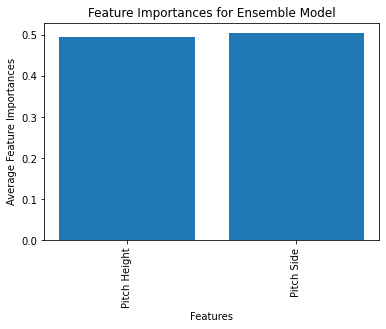

In [13]:
features_list = ['Pitch Height', 'Pitch Side']

plt.bar(features_list, average_feature_importances)
plt.xlabel('Features')
plt.ylabel('Average Feature Importances')
plt.title('Feature Importances for Ensemble Model')
plt.xticks(rotation=90)
plt.show()

In [14]:
X = dfbr[['Pitch Height', 'Pitch Side']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfbr['RV']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Make predictions on the training set using all the models
linear_pred_train = linear_model.predict(X_train_scaled)
rf_pred_train = random_forest_model.predict(X_train_scaled)
xgb_pred_train = xgb_model.predict(X_train_scaled)
svr_pred_train = svr_model.predict(X_train_scaled)
keras_nn_pred_train = nn_model.predict(X_train_scaled).flatten()

411/411 [==============================] - 1s 2ms/step


In [16]:
# Make predictions on the test set using all the models
linear_pred_test = linear_model.predict(X_test_scaled)
rf_pred_test = random_forest_model.predict(X_test_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)
svr_pred_test = svr_model.predict(X_test_scaled)
keras_nn_pred_test = nn_model.predict(X_test_scaled).flatten()

103/103 [==============================] - 0s 2ms/step


In [17]:
# Combine predictions using averaging for the training set
ensemble_predictions_train = (linear_pred_train + rf_pred_train + xgb_pred_train + svr_pred_train + keras_nn_pred_train) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the training set
ensemble_df_train = pd.DataFrame({'xRV': ensemble_predictions_train}, index=X_train.index)

In [18]:
# Combine predictions using averaging for the test set
ensemble_predictions_test = (linear_pred_test + rf_pred_test + xgb_pred_test + svr_pred_test + keras_nn_pred_test) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the test set
ensemble_df_test = pd.DataFrame({'xRV': ensemble_predictions_test}, index=X_test.index)

In [19]:
# Concatenate the training and test set DataFrames
ensemble_df = pd.concat([ensemble_df_train, ensemble_df_test])

In [20]:
# Predict using the model and store results in a new DataFrame
# dfb_predictions = dfb.copy()

# Merge the predictions with the original DataFrame based on index
dfbr = dfbr.merge(ensemble_df[['xRV']], left_index=True, right_index=True)

# Create a new column with predicted run value times 100 called xRV/100
dfbr['xRV/100'] = dfbr['xRV'] * 100

In [21]:
# Create a new column called xRV/100 scaled negative which is xRV/100 - max(xRV/100)
dfbr = dfbr.assign(xRV100_scaled_negative=dfbr['xRV/100'] - dfbr['xRV/100'].max())

# Create a new column which is the absolute value of xRV/100 scaled negative
dfbr = dfbr.assign(xRV100_scaled_negative_abs=dfbr['xRV100_scaled_negative'].abs())

In [22]:
# Calculate the Location+ mean for the whole datset
mean_location_plus = dfbr['xRV100_scaled_negative_abs'].mean()

# Calculate the 'Location+' values
dfbr['Location+'] = (dfbr['xRV100_scaled_negative_abs'] / mean_location_plus) * 100

In [23]:
dfbr['Location+'].describe()

count    16427.000000
mean       100.000000
std         20.255347
min          0.000000
25%         84.558421
50%        104.563241
75%        116.183218
max        151.951610
Name: Location+, dtype: float64

In [24]:
# Sort the DataFrame by 'Location+' values in descending order
dfbr_sorted = dfbr.sort_values(by='Location+', ascending=False)

# Reset the index of the sorted DataFrame
dfbr_sorted.reset_index(drop=True, inplace=True)

dfbr_sorted = dfbr_sorted[['Pitcher', 'Pitch Type', 'Pitch Result', 'Pitcher Team', 'P Side', 'Velocity', 'RV', 'Pitch Height', 'Pitch Side', 'Location+']]

dfbr_sorted.head(20)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,P Side,Velocity,RV,Pitch Height,Pitch Side,Location+
0,Brendan Lysik,Fastball,InPlay,Brewster,Left,85.80113,-0.2733,3.41317,-0.51349,151.951610
1,Ethan Lanthier,Fastball,StrikeSwinging,Hyannis,Right,93.11331,-0.1260,3.68517,-0.08453,151.768176
2,Garrett Horn,Fastball,StrikeSwinging,Bourne,Left,94.41364,-0.1260,3.65178,-0.29615,148.683267
3,Mason Murdock,Fastball,InPlay,Cotuit,Right,88.91766,-0.2733,1.75439,0.27858,148.316274
4,Miles Langhorne,Fastball,FoulBall,Chatham,Right,96.53041,-0.0476,3.39531,-0.08437,147.692240
5,Zachary Voelker,Fastball,StrikeSwinging,Hyannis,Right,92.51583,-0.1260,3.83311,0.30310,146.879673
6,Xavier Martinez,Fastball,StrikeCalled,Harwich,Right,96.72876,-0.0821,3.65408,-0.31998,146.213617
7,Collin Caldwell,Fastball,FoulBall,Harwich,Left,91.13550,-0.0476,3.57209,-0.24864,145.720713
8,Brendan Lysik,Fastball,InPlay,Brewster,Left,87.39740,-0.2733,3.62436,0.25368,145.392751
9,Collin Caldwell,Fastball,InPlay,Harwich,Left,90.12238,-0.2733,2.15774,-0.78153,144.922908


In [37]:
dfbr_trial = dfbr_sorted[['Pitcher', 'Pitch Result', 'Pitch Height', 'Pitch Side', 'Location+']]
dfbr_trial = dfbr_trial.head(5)

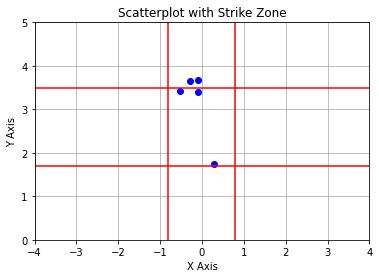

In [38]:
# Define the strike zone boundaries
y_boundarylow = 1.7
y_boundaryhigh = 3.5

x_boundarylow = -0.8
x_boundaryhigh = 0.8

# Create a scatterplot
plt.scatter(dfbr_trial['Pitch Side'], dfbr_trial['Pitch Height'], color='blue', label='Data Points')

# Add the strike zone lines
plt.axvline(x=x_boundarylow, color='red', linestyle='-', label='Strike Zone')
plt.axvline(x=x_boundaryhigh, color='red', linestyle='-')
plt.axhline(y=y_boundarylow, color='red', linestyle='-')
plt.axhline(y=y_boundaryhigh, color='red', linestyle='-')

# Set labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Scatterplot with Strike Zone')

# Set plot limits
plt.xlim(-4, 4)
plt.ylim(0, 5)

# Show the plot
plt.grid()
plt.show()


In [27]:
average_fb_Stuff = dfbr[dfbr['Pitcher Team'] == 'Hyannis'].groupby('Pitcher')['Location+'].mean()
#average_fb_Stuff = dfbr[dfbr['Pitch Type'] == 'Fastball'].groupby('Pitcher')['Location+'].mean()
#average_fb_Stuff = dfbr[(dfbr['Pitcher Team'] == 'Hyannis')]
average_fb_Stuff = average_fb_Stuff.round(2)

# Sort the Series in descending order based on the average Stuff+ values
average_fb_Stuff_sorted = average_fb_Stuff.sort_values(ascending=False)

average_fb_Stuff_sorted

Pitcher
Tyler LeBlanc        116.36
JB Middleton         114.03
Coulson Buchanan     107.76
Tony Robie           106.82
John Dwyer           106.14
Carter Lovasz        105.69
Hayden Frank         104.88
Will Armistead       104.27
Evan Whiteaker       102.91
Joe Glassey          102.67
Kros Sivley          102.07
Zachary Voelker      102.00
Dennis Colleran      101.93
Bradley Hodges       101.47
Thaniel Trumper      101.16
Michael Rodriguez    100.80
Matt Maloney         100.54
Mitch Farris         100.42
Mason Nichols        100.34
David Case           100.05
Griffin O'Connor     100.05
Jamie Arnold          99.31
Cade Obermueller      99.00
Ty Good               98.50
Simon Miller          98.39
Hiroyuki Yamada       97.86
Jackson Soucie        97.12
Collin Rothermel      96.73
Darin Horn            96.23
Jay Driver            95.32
Ethan Bates           94.28
Ethan Lanthier        93.39
Eli Trop              83.51
Name: Location+, dtype: float64

In [35]:
dfbr = dfbr.round(2)
average_fb_location = dfbr.groupby('Pitcher')['Location+'].mean()

# Sort the Series in descending order based on the average Stuff+ values
average_fb_location_sorted = average_fb_location.sort_values(ascending=False)

In [36]:
average_fb_location_sorted.round(2).head(30)

Pitcher
Randall Alejo       132.70
Ben Jacobs          126.34
Justin Lovell       124.18
Will Jones          118.00
Garrett Coe         117.24
Tyler LeBlanc       116.36
JB Middleton        114.03
Carson Swilling     113.21
Zachary Joyce       112.93
Matt Boynton        112.54
Blake Purnell       110.81
Matt Wilkinson      110.32
Nolan Morr          109.87
AJ Causey           109.61
Jack Bowery         109.38
David Falco         109.30
John Holobetz       108.66
Bryce Eblin         108.55
Chase Hopewell      108.38
Andrew Shaffner     108.04
Coulson Buchanan    107.76
Aiden Jimenez       107.41
Anthony Defabbia    107.32
Thomas Splaine      107.15
Max Banks           106.94
Mark Manfredi       106.92
Josh Timmerman      106.83
Tony Robie          106.82
Trevin Hope         106.80
Kyle Scott          106.79
Name: Location+, dtype: float64